In [1]:
!sudo apt-get update >& /dev/null
!apt-get install -y xvfb x11-utils >& /dev/null
!pip install gym==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* >& /dev/null
!pip install stable-baselines3 >& /dev/null
!pip install highway-env >& /dev/null

In [2]:
!rm -rf ./video
!mkdir -p ./video 

In [3]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1368, 768))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1368x768x24', ':1017'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1368x768x24', ':1017'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [4]:
def show_video(idx=0):
    # This function loads the data video inline into the colab notebook.
    # By reading the video stored by the Monitor class.
  mp4list = glob.glob('video/*.mp4')
  mp4list = sorted(mp4list)
  if len(mp4list) > 0:
    mp4 = mp4list[idx]
    print(mp4)
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test"
                controls style="height: 256px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

# SARSA($\lambda$)


In [5]:
from collections import namedtuple
from functools import reduce
import gym
import highway_env
import numbers
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from time import sleep
from tqdm import tqdm
from typing import Tuple, Dict, Hashable, Any, Union

In [6]:
Transform = namedtuple('Transform', ['original', 'target', 'convert_to', 'convert_from'])

class _LinearTransformArray(object):
  def __init__(self, offset, slope, shape, dtype=float):
    self._offset = offset
    self._slope = slope
    self._dtype = dtype
    self._shape = shape

  def __call__(self, x):
    return np.reshape(self._offset + self._slope * x, self._shape).astype(self._dtype)

def discretize(space, steps):
  """
  Creates a discretized version of `space` and returns
  a `Transform` that contains the conversion functions.
  If the space is already discrete, the identity
  is returned. The steps are distributed such that the old
  minimum and maximum value can still be reached in the new
  domain.
  :param gym.Space space: The space to be discretized.
  :param int|Iterable steps: The number of discrete steps to produce
                for each continuous dimension. Can be an
                Integer or a list.
  :raises ValueError: If less than two steps are are supplied.
  :return Transform: A `Transform` to the discretized space.
  """

  if isinstance(steps, numbers.Integral):
    steps = np.full(space.low.shape, steps)

  if not isinstance(steps, numbers.Integral):
    steps = np.array(steps, dtype=int)
    if (steps < 2).any():
      raise ValueError("Need at least two steps to discretize, got {}".format(steps))
  elif steps < 2:
    raise ValueError("Need at least two steps to discretize, got {}".format(steps))

  if steps.shape != space.shape:
    raise ValueError("Supplied steps {} have invalid shape".format(steps))

  discrete_space = gym.spaces.MultiDiscrete(steps.flatten())
  lo = space.low.flatten()
  hi = space.high.flatten()

  convert = _LinearTransformArray(lo, (hi - lo) / (steps - 1.0), space.shape)
  back = _LinearTransformArray(-lo * (steps - 1) / (hi - lo), (steps - 1.0) / (hi - lo), (len(steps),), int)

  return Transform(original=space, target=discrete_space, convert_from=convert, convert_to=back)


class MyWrapper(gym.ObservationWrapper):
  """
  Wraps the env such that the new env has a discrete
  observation space.
  """
  def __init__(self, env, steps = None):
    super().__init__(env)
    trafo = discretize(env.observation_space, steps)
    self.observation_space = trafo.target
    self.observation = trafo.convert_to

observation_space = gym.spaces.Box(
            np.array([-1.2, -0.07], dtype=np.float32),
            np.array([ 0.6,  0.07], dtype=np.float32), 
            dtype=np.float32
)

trafo = discretize(observation_space, (20, 30))

assert isinstance(trafo.target, gym.spaces.MultiDiscrete)
assert np.all(trafo.target.nvec == np.array([20, 30]))
assert np.all(trafo.convert_from((0,0)) - [-1.2, -0.07] < [0.001, 0.001])
assert np.all(trafo.convert_to([-1.2, -0.07]) == (0, 0))

print(trafo.convert_to([0.6001, 0.07001]))

[19 29]


In [22]:
def init_q(s, a, type="ones"):
  """
  @param s the number of states
  @param a the number of actions
  @param type random, ones or zeros for the initialization
  """
  if type == "ones":
    return np.ones((*s, a))
  elif type == "random":
    return np.random.random((*s, a))
  elif type == "zeros":
    return np.zeros((*s, a))

def epsilon_greedy(Q, epsilon, n_actions, s):
  """
  @param Q Q values state x action -> value
  @param epsilon for exploration
  @param s number of states
  @param train if true then no random actions selected
  """
  if np.random.rand() < 1-epsilon:
    action = np.argmax(Q[(*s),])
  else:
    action = np.random.randint(0, n_actions)
  return action

def test_agent(env, n_tests, n_actions, policy=None):
  total_rewards = []
  for test in tqdm(range(n_tests)):
    s = env.reset()
    done = False
    total_reward = 0
    while not done:
      env.render()

      a = policy[tuple(s)]

      s, reward, done, info = env.step(a)
      total_reward += reward
      if done:
        total_rewards.append(total_reward)
        break
  return total_rewards

def sarsa(episodes, initial_lr, min_lr, gamma, initial_eps, min_eps, n_tests=30, test=True):
  """
  @param initial_lr initial learning rate
  @param min_lr minimum learning rate
  @param gamma decay factor
  @param initial_eps epsilon for exploration
  @param min_eps minimum epsilon for exploration
  @param n_tests number of test episodes
  """
  n_states, n_actions = env.observation_space.nvec, env.action_space.n
  Q = init_q(n_states, n_actions, type="zeros")

  train_total_rewards = []
  test_total_rewards = []
  for episode in tqdm(range(episodes)):
    total_reward = 0
    s = env.reset()
    a = epsilon_greedy(Q, min_eps, n_actions, s)
    done = False
    while not done:
      s_, reward, done, info = env.step(a)
      total_reward += reward
      a_ = epsilon_greedy(Q, min_eps, n_actions, s_)
      if done:
        Q[(*s), a] += min_lr*(reward  - Q[(*s), a])
      else:
        Q[(*s), a] += min_lr*(reward + gamma * Q[(*s_), a_] - Q[(*s), a])
      s, a = s_, a_

      if done:
        train_total_rewards.append(total_reward)
        # decay epsilon & alpha
        break

  if test:
    pi = np.argmax(Q, axis=2)
    test_total_rewards = test_agent(env, n_tests, n_actions, pi)

  return train_total_rewards, test_total_rewards

def qlearning(episodes, initial_lr, min_lr, gamma, initial_eps, min_eps, n_tests=30, test=True):
  """
  @param alpha learning rate
  @param gamma decay factor
  @param epsilon for exploration
  @param n_tests number of test episodes
  """
  n_states, n_actions = env.observation_space.nvec, env.action_space.n
  Q = init_q(n_states, n_actions, type="zeros")

  reduction_eps = (initial_eps - min_eps) / episodes
  eps = initial_eps

  train_total_rewards = []
  test_total_rewards = []
  for e in tqdm(range(episodes)):
    s = env.reset()
    eta = max(min_lr, initial_lr*(0.85**(e//100)))
    total_reward = 0
    done = False
    while not done:
      a = epsilon_greedy(Q, eps, n_actions, s)
      s_, reward, done, info = env.step(a)
      total_reward += reward

      if done:
        Q[(*s), a] += eta*(reward  - Q[(*s), a])
      else:
        Q[(*s), a] += eta*(reward + gamma*np.max(Q[(*s_),]) - Q[(*s), a])

      s = s_

      if done:
        train_total_rewards.append(total_reward)
        # decay epsilon & alpha
        eps -= reduction_eps
        break
  
  if test:
    pi = np.argmax(Q, axis=2)
    test_total_rewards = test_agent(env, n_tests, n_actions, pi)

  return train_total_rewards, test_total_rewards

In [23]:
env = gym.make('MountainCar-v0')
print(env.observation_space)
env1 = gym.wrappers.Monitor(env, './video', force=True)
print(env.observation_space)
env = MyWrapper(env1, (36, 36))
print(env.observation_space)

env.seed(0)

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
MultiDiscrete([36 36])


[0]

In [24]:
initial_lr = 0.4
min_lr = 0.2
gamma = 0.9
initial_eps = 0.8
min_eps = 0
train_total_rewards, test_total_rewards = qlearning(5000, initial_lr, min_lr, gamma, initial_eps, min_eps)

100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


In [27]:
initial_lr = 0.4
min_lr = 0.2
gamma = 0.9
initial_eps = 0.8
min_eps = 0.2
train_total_rewards_s, test_total_rewards_s = sarsa(5000, initial_lr, min_lr, gamma, initial_eps, min_eps)

100%|██████████| 30/30 [00:08<00:00,  3.75it/s]


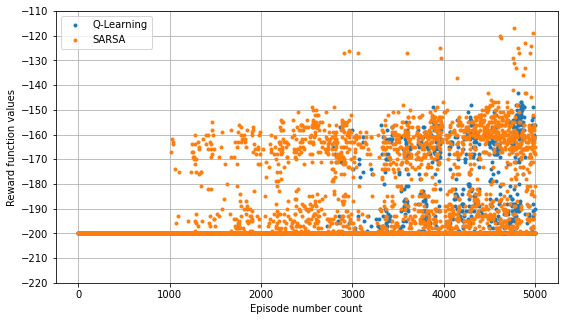

In [37]:
# This graph shows the saturation of rewards to a minimum under 1000 episodes.
fig, ax = plt.subplots(figsize = (9, 5))
plt.plot(train_total_rewards[:],'.')
plt.plot(train_total_rewards_s[:],'.')
plt.legend(['Q-Learning', 'SARSA'])
plt.yticks(range(-110, -230, -10))
plt.ylabel("Reward function values")
plt.xlabel("Episode number count")
plt.grid()
plt.show()

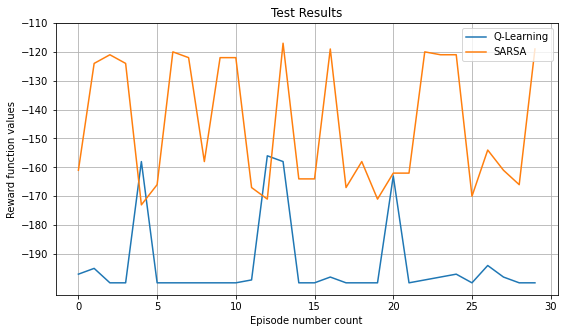

In [36]:
fig, ax = plt.subplots(figsize = (9, 5))
plt.plot(test_total_rewards[:], '-')
plt.plot(test_total_rewards_s[:], '-')
plt.legend(['Q-Learning', 'SARSA'])
plt.yticks(range(-110, -200, -10))
plt.title("Test Results")
plt.ylabel("Reward function values")
plt.xlabel("Episode number count")
plt.grid()
plt.show()

In [19]:
show_video(idx=-1)

video/openaigym.video.1.13118.video010000.mp4


# Hindsight Experience Replay


In [38]:
from stable_baselines3 import HER, SAC, DDPG
from stable_baselines3.common.noise import NormalActionNoise

In [39]:
env = gym.make("parking-v0")

In [40]:
# SAC hyperparams:
model = HER('MlpPolicy', env, SAC, n_sampled_goal=4,
            goal_selection_strategy='future', online_sampling=True,
            verbose=1, buffer_size=int(1e6),
            learning_rate=1e-3,
            gamma=0.95, batch_size=256,
            policy_kwargs=dict(net_arch=[256, 256, 256]), max_episode_length=100)

Using cpu device


In [42]:
# Train for 1e5 steps
model.learn(int(1e5))
# Save the trained agent
model.save('her_sac_parking')

Streaming output truncated to the last 5000 lines.
|    success rate    | 0.99     |
| time/              |          |
|    episodes        | 2044     |
|    fps             | 16       |
|    time_elapsed    | 4434     |
|    total timesteps | 74499    |
| train/             |          |
|    actor_loss      | 1.58     |
|    critic_loss     | 0.00594  |
|    ent_coef        | 0.00703  |
|    ent_coef_loss   | 0.787    |
|    learning_rate   | 0.001    |
|    n_updates       | 74398    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.1     |
|    ep_rew_mean     | -7.59    |
|    success rate    | 0.99     |
| time/              |          |
|    episodes        | 2048     |
|    fps             | 16       |
|    time_elapsed    | 4440     |
|    total timesteps | 74582    |
| train/             |          |
|    actor_loss      | 1.3      |
|    critic_loss     | 0.00413  |
|    ent_coef        | 0.00697 

In [45]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecVideoRecorder
from tqdm.notebook import trange

video_length = 1000

env = gym.make("parking-v0")
env = DummyVecEnv([lambda: env])

obs = env.reset()

env = VecVideoRecorder(env, './video/', record_video_trigger=lambda x: True, video_length=video_length)

loaded_model = HER.load('her_sac_parking', env=env)

for _ in trange(video_length + 1, desc="Generate video frames"):
  action, _ = loaded_model.predict(obs, deterministic=False)
  obs, _, _, _ = env.step(action)
  env.render()

env.close()

Saving video to  /content/video/rl-video-step-1-to-step-1001.mp4



In [46]:
show_video()

video/rl-video-step-1-to-step-1001.mp4


# Let's explore a model based approach

from this [notebook](https://colab.research.google.com/github/eleurent/highway-env/blob/master/scripts/parking_model_based.ipynb#scrollTo=FFsgc7gffvi0)


In [47]:
env = gym.make("parking-v0")
env = gym.wrappers.Monitor(env, './video', force=True, video_callable=lambda episode: True)

obs = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render()
env.close()

In [48]:
show_video()

video/openaigym.video.3.13118.video000000.mp4


## Let's gather data

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple

Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=1000, action_repeat=2):
    data, done = [], True
    for _ in trange(size, desc="Collecting interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            previous_obs = env.reset() if done else obs
            obs, reward, done, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
    return data

data = collect_interaction_data(env)
print("Sample transition:", data[0])


Sample transition: Transition(state=tensor([ 0.0000,  0.0000,  0.0000, -0.0000,  0.9365, -0.3506]), action=tensor([-0.4806,  0.5669]), next_state=tensor([-3.1794e-04,  3.9837e-05, -8.9927e-02,  3.3971e-02,  9.3548e-01,
        -3.5339e-01]))


## Let's create an approximate (linear) model


[paper](https://www.diva-portal.org/smash/get/diva2:1372031/FULLTEXT01.pdf)

```
# This is formatted as code
```



In [50]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])


print("Forward initial model on a sample transition:", \
      dynamics(data[0].state.unsqueeze(0), data[0].action.unsqueeze(0)).detach())

Forward initial model on a sample transition: tensor([[ 0.0221, -0.0217,  0.0824, -0.0425,  0.9502, -0.3462]])


## Fit the model on data
We can now train our model $f_\theta$ in a supervised manner to minimize an MSE loss $L^2(f_\theta; E)$ over our experience batch $E$ by stochastic gradient descent:

$$L^2(f_\theta; E) = \frac{1}{|E|}\sum_{s_t,a_t,s_{t+1}\in E}||s_{t+1}- f_\theta(s_t, a_t)||^2$$

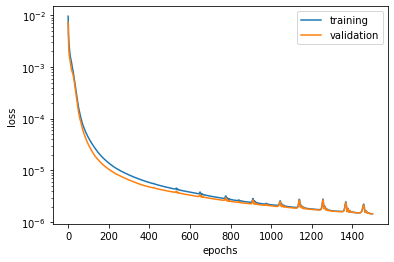

In [51]:
import matplotlib.pyplot as plt


optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)
    for epoch in trange(epochs, desc="Train dynamics"):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

train(dynamics, data, validation_data)

## Plot sample trajectories for given throttle, steering angle
Here we plot 2 throttle levels (0.4 and 0.8) and 3 streering angles (-0.5 i.e. right, 0 i.e. straight & 0.5 i.e. left)

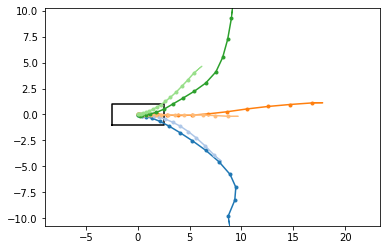

In [52]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()
    
visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

## Compute the reward

The state is made of:
$ x, y, v_x, v_y, cos(\theta), sin(\theta)$

The reward is a weighed scalar product between the state & goal_state (the parking lot in our case)

In [53]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.REWARD_WEIGHTS)
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards


obs = env.reset()

print(obs)

print("Reward of a sample transition:", 
      reward_model(torch.Tensor(obs["observation"]).unsqueeze(0), torch.Tensor(obs["desired_goal"])))

{'observation': array([ 0.        ,  0.        ,  0.        , -0.        ,  0.98087434,
       -0.19464208]), 'achieved_goal': array([ 0.        ,  0.        ,  0.        , -0.        ,  0.98087434,
       -0.19464208]), 'desired_goal': array([-3.000000e-01, -1.400000e-01,  0.000000e+00,  0.000000e+00,
        6.123234e-17, -1.000000e+00])}
Reward of a sample transition: tensor([-0.6146])


## Using CEM to plan trajectory

Why not considering Iterative LQR?

In [54]:
def cem_planner(state, goal, action_size, horizon=5, population=100, selection=10, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = action_mean + action_std * torch.randn(horizon, population, action_size)
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=5)
        # 2. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean, action_std = best_actions.mean(dim=1, keepdim=True), best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)
  
  
# Run the planner on a sample transition
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0])

print("Planned action:", action)

Planned action: tensor([-0.9789, -0.1487])


## Let's visualize the plan

In [55]:
env = gym.make("parking-v0")
env = gym.wrappers.Monitor(env, './video', force=True, video_callable=lambda episode: True)
for episode in trange(3, desc="Test episodes"):
    obs, done = env.reset(), False
    while not done:
        action = cem_planner(torch.Tensor(obs["observation"]),
                             torch.Tensor(obs["desired_goal"]),
                             env.action_space.shape[0])
        obs, reward, done, info = env.step(action.numpy())
env.close()
show_video()


video/openaigym.video.4.13118.video000000.mp4
